# Regression on different datasets using the new kernel

In [43]:
import matplotlib.pyplot as plt # 3.6
import numpy as np # 1.22.4
import tensorflow as tf # 2.11.0
import gpflow # 2.7.0
import pandas as pd
import tensorflow_probability as tfp
from tensorflow import keras
import seaborn as sns
import torch
from torch.utils.data import  TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow_probability as tfp
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
plt.rcParams["figure.figsize"] = (12, 6)
plt.style.use("ggplot")
print('tensorflow ', tf.__version__) 
print('pytorch ', torch.__version__) 
print('numpy ', np.__version__) 
print('gpflow ', gpflow.__version__) 
print('pandas ', pd.__version__) 

tensorflow  2.11.0
pytorch  1.13.1
numpy  1.22.4
gpflow  2.7.0
pandas  1.5.3


Define utilities functions

In [107]:
def create_dataset(dataset, fold, static_train_test=True):
    dataset_path = ('../../data/' + dataset + '.pth')
    dataset = TensorDataset(*torch.load(dataset_path))
    X, Y = dataset.tensors
    X, Y = X.numpy().astype('float64'), Y.numpy().astype('float64')
    if static_train_test:
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=fold)
        Y_train_mean, Y_train_std = Y_train.mean(0), Y_train.std(0) + 1e-9
        Y_train = (Y_train - Y_train_mean) / Y_train_std
        Y_test = (Y_test - Y_train_mean) / Y_train_std
        return X_train, Y_train, X_test, Y_test, Y_train_mean, Y_train_std
    else:
        return X, Y
def plot_matrix(M=None, cmap='vlag', annot=True, correlation=False):
    """
    M: Matrix to be visualized with a color mapping
    correlation: plot the correlation matrix of the dataset M
    cmap: type of mapping
    ---
    It displays a matrix represented with a color scheme
    """
    if correlation:
        index_values = ['%d'%(i) for i in range(M.shape[0])]
        column_values = ['%d'%(i) for i in range(M.shape[1])]
        df = pd.DataFrame(data = M, index = index_values, columns = column_values)
        corr = df.corr()
        sns.heatmap(corr, annot=annot, cmap=cmap)
    else:
        min = np.min(M)
        max = np.max(M)
        center = (min+max)/2
        sns.heatmap(M, annot=annot, cmap=cmap, vmax=max, vmin=-max, center=0, linewidth=.5)

def compare_matrix(M1, M2, cmap='vlag'):
    fig, axes = plt.subplots(1, 2, figsize=(24,6))
    min = np.min(M1)
    max = np.max(M1)
    center = (min+max)/2
    sns.heatmap(M1, ax=axes[0], annot=True, cmap=cmap, vmax=max, vmin=-max, center=0, linewidth=.5)
    axes[0].set_title('LambdaRBF')

    min = np.min(M2)
    max = np.max(M2)
    center = (min+max)/2
    sns.heatmap(M2, ax=axes[1], annot=True, cmap=cmap, vmax=max, vmin=-max, center=0, linewidth=.5)
    axes[1].set_title('ARD RBF')
    plt.show()

Load Boston dataset

In [7]:
X_train, Y_train,  X_test, Y_test, Y_train_mean, Y_train_std = create_dataset('boston', 0)
D = X_train.shape[1]

## Full Gaussian Kernel Design

In [9]:
def get_lower_triangular_from_diag(d):
    """
    diag: diagonal of lengthscales parameter [D,]
    ---
    Σ=inv(Λ) -> diagonal matrix with lengthscales on the diagonal (RBF)
    The diagonal of Λ is obtained as 1/(l^2), l is a lengthscale
    returns: L, Λ=LLᵀ
    """
    # Define the lengthscales according to the standard RBF kernel
    lengthscales = tf.constant([d**0.5]*d, dtype=tf.float64)
    # Obtain the matrix L such that LLᵀ=Λ and Λ=inv(diag(lengthscales))
    Lambda = tf.linalg.diag(1/(lengthscales**2))
    L = tf.linalg.cholesky(Lambda) # L = Cholesky(inv(diag(lengthscales)))
    return tfp.math.fill_triangular_inverse(L) 

def get_lower_triangular_uniform_random(d):
    full_L = np.random.uniform(-1,1,(d,d)) # Non-symmetric matrix where -1 <= full_L[i,j] <= 1
    Lambda = full_L @ np.transpose(full_L) # Λ=LLᵀ
    L = tf.linalg.cholesky(Lambda)
    return tfp.math.fill_triangular_inverse(L)

In [17]:
class LambdaRBF(gpflow.kernels.Kernel):  

    def __init__(self, **kwargs):
        randomized = kwargs["randomized"]
        d = kwargs["d"]
        variance = kwargs["variance"]
        if not randomized:
            L = get_lower_triangular_from_diag(d)
        else:
            L = get_lower_triangular_uniform_random(d)
        super().__init__()
        self.L = gpflow.Parameter(L, transform=None, dtype=tf.float64, name='L')
        self.variance = gpflow.Parameter(variance, transform=gpflow.utilities.positive(), dtype=tf.float64, name='variance')

    def K(self, X, X2=None):
        """
            X: matrix NxD
            X2: matrix NxD
            ---
            Returns Kernel matrix as a 2D tensor
        """
        if X2 is None:
            X2 = X
        #N1 = X.shape[0] WORKS
        #N2 = X2.shape[0] WORKS
        N1 = tf.squeeze(tf.shape(X)[:-1])
        N2 = tf.squeeze(tf.shape(X2)[:-1])
        Lambda = self.precision() # recover LLᵀ

        # compute z, z2
        z = self._z(X, Lambda) # N1x1 array
        z2 = self._z(X2, Lambda) # N2x1 array
        # compute X(X2Λ)ᵀ
        X2Lambda = tf.linalg.matmul(X2, Lambda)
        XX2LambdaT = tf.linalg.matmul(X, tf.transpose(X2Lambda)) # N1xN2 matrix
        # compute z1ᵀ 
        ones_N2 = tf.ones(shape=(N2,1), dtype=tf.float64) # N2x1 array
        zcol = tf.linalg.matmul(z, tf.transpose(ones_N2)) # N1xN2 matrix
        # compute 1z2ᵀ 
        ones_N1 = tf.ones(shape=(N1,1), dtype=tf.float64) # N1x1 array
        zrow = tf.linalg.matmul(ones_N1, tf.transpose(z2)) # N1xN2 matrix

        exp_arg = zcol - 2*XX2LambdaT + zrow
        Kxx = tf.math.exp(-0.5 * exp_arg)
        return self.variance * Kxx
    
    def K_diag(self, X):
        return tf.fill(tf.shape(X)[:-1], tf.squeeze(self.variance))
    
    def _z(self, X, Lambda):
        XLambda = tf.linalg.matmul(X, Lambda)
        XLambdaX = tf.math.multiply(XLambda, X)
        return tf.math.reduce_sum(XLambdaX, axis=1, keepdims=True)
    
    def precision(self):
        L = tfp.math.fill_triangular(self.L) # recover L matrix from L array
        Lambda = tf.linalg.matmul(L, tf.transpose(L))
        return Lambda
    
    def __str__(self):
        Lambda = self.precision()
        return 'Variance: {}\nLambda: {}'.format(self.variance, Lambda)
    
class ARD_gpflow(gpflow.kernels.SquaredExponential):
    def __init__(self, **kwargs):
        randomized = kwargs["randomized"]
        d = kwargs["d"]
        variance = kwargs["variance"]
        if not randomized:
            lengthscales = lengthscales = tf.constant([d**0.5]*d, dtype=tf.float64)
        else:
            lengthscales = np.random.uniform(0.5,3,d)      
        super().__init__(variance, lengthscales)
    
    def precision(self) -> tf.Tensor:
        return tf.linalg.diag(self.lengthscales**(-2))  

In [89]:
class GPRLasso(gpflow.models.GPR):
    """
    Basic Gaussian process regression, but L1 penalty term is added to 
    the loss. This model assumes that the underlying kernel is either 
    full Gaussian kernel or ARD kernel.
    """
    
    def __init__(self, **kwargs):

        data = kwargs["data"]
        kernel = kwargs["kernel"]
        super(GPRLasso, self).__init__((data.train_X, data.train_y), kernel)

        self.lasso = 0 if "lasso" not in kwargs else kwargs["lasso"]
        d = self.data[0].shape[1]

    def maximum_log_likelihood_objective(self) -> tf.Tensor:
        return super().log_marginal_likelihood() - self.lasso*tf.math.reduce_sum(tf.abs(self.kernel.precision()))

Show that the Lambda RBF kernel is equivalent in the computation of the kernel matrix

In [31]:
LRBF = LambdaRBF(variance=1.0, randomized=False, d=D)
lrbf = LRBF.K(X_train)[5,3]

# Standard RBF kernel
RBF = gpflow.kernels.SquaredExponential(variance=1, lengthscales=(D**0.5)*np.ones(D))
rbf = RBF.K(X_train)[5,3]
print('LambdaRBF val: ', lrbf)
print('RBF val: \t',rbf)

LambdaRBF val:  tf.Tensor(0.3518335889365919, shape=(), dtype=float64)
RBF val: 	 tf.Tensor(0.3518335889365918, shape=(), dtype=float64)


## Compare the RBF kernel with LambdaRBF with equivalent starting lengthscales

### The Covariance matrix

We are going to extend the Automatic Relevance Determination techique tipically used togheter with stationary kernels like Squared Exponential (RBF).

We are working on the prior probabability $p(\textbf{f}|\Theta)$. The prior knowledge is expressed by the precomputed Kernel matrix $K_{xx|\Theta}$ where $K_{xx|\Theta}[i,j] = k(x_i,x_j|\Theta)$. \\
The RBF kernel function $k$ is defined as:
$$k(x_i,x_j|\sigma_f^2,\Lambda) = \sigma_f^2e^{-\frac{1}{2}(x_i-x_j)^T\Lambda(x_i-x_j)}$$
where $\Lambda$ is the precision matrix of the kernel.

In ARD the precision matrix of the kernel is of the form:
$$diag([\alpha_0,\alpha_1,...,\alpha_{D-1}])$$ 
where $D$ is the number of features. The values on the diagonal are called lengthscales because they represent a form of scaling of the squared norm that is computed among couples of feature vectors. 

What we are willing to do is extending the ARD mechanism to a more general one where we can optimize for the entire precision matrix $\Lambda$ instead of only the diagonal (explain here the link between a zero in the precision matrix and conditional independence). For this purpose we are going to design a modified version of the RBF kernel in which the trainable hyperparameters are $\sigma_f^2$ and the full matrix $\Lambda$

In [27]:
l_i = D**0.5
lengthscales_array = l_i*np.ones(D)
print('Lengthscales: ', lengthscales_array)

Lengthscales:  [3.60555128 3.60555128 3.60555128 3.60555128 3.60555128 3.60555128
 3.60555128 3.60555128 3.60555128 3.60555128 3.60555128 3.60555128
 3.60555128]


$$k(x_i,x_j|\sigma_f^2,\Lambda) = \sigma_f^2e^{||\frac{x_i-x_j}{\textbf{l}}||^2}$$
where $\textbf{l}$ is a $D$-dimensional array containing the lengthscales of each dimension $[l_0,l_1,...,l_{D-1}]$. If we suppose $D=2$ we can express the scaled norm between two samples as:
$$||\frac{x_i-x_j}{\textbf{l}}||^2 = (x_i-x_j)^T\begin{bmatrix} \lambda_0 & 0 \\ 0 & \lambda_1 \end{bmatrix}(x_i-x_j) = \lambda_0(x_{i,0}-x_{j,0})^2 + \lambda_1(x_{i,1}-x_{j,1})^2$$

$$||\frac{x_i-x_j}{\textbf{l}}||^2 = (\frac{x_i-x_j}{l_0})^T(\frac{x_i-x_j}{l_1}) = \begin{bmatrix}\frac{x_{i,0}-x_{j,0}}{l_0} & \frac{x_{i,1}-x_{j,1}}{l_1}\end{bmatrix}\begin{bmatrix}\frac{x_{i,0}-x_{j,0}}{l_0} \\ \frac{x_{i,1}-x_{j,1}}{l_1}\end{bmatrix} = \frac{1}{l_0^2}(x_{i,0}-x_{j,0})^2 + \frac{1}{l_1^2}(x_{i,1}-x_{j,1})^2$$

$$\lambda_i = \frac{1}{l_i^2}$$
$$l_i = \sqrt{\frac{1}{\lambda_i}}$$

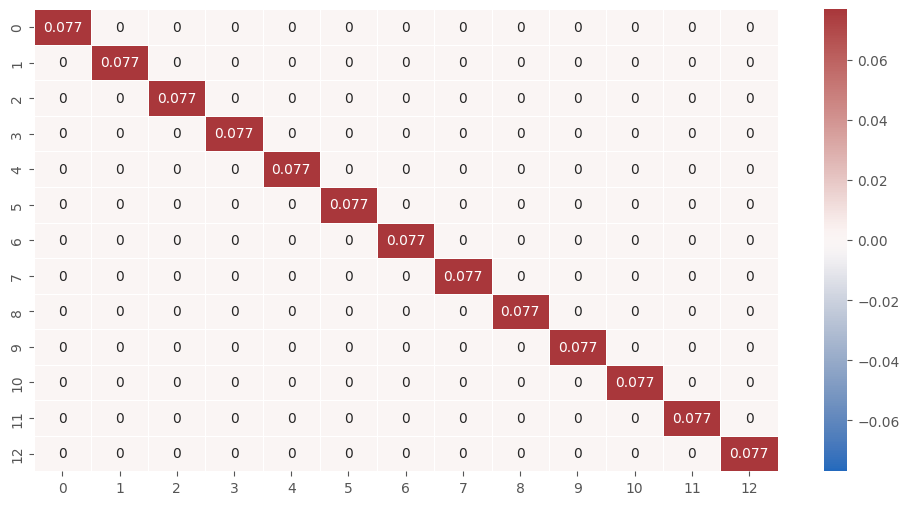

In [32]:
plot_matrix(LRBF.precision())

In [33]:
print('lambda_i = %.3f'%(1/l_i**2))

lambda_i = 0.077


### LambdaRBF kernel - no priors

In [103]:
class GPRLasso(gpflow.models.GPR):
    """
    Basic Gaussian process regression, but L1 penalty term is added to 
    the loss. This model assumes that the underlying kernel is either 
    full Gaussian kernel or ARD kernel.
    """
    
    def __init__(self, **kwargs):

        data = kwargs["data"]
        kernel = kwargs["kernel"]
        super(GPRLasso, self).__init__((data[0], data[1]), kernel)

        self.lasso = 0 if "lasso" not in kwargs else kwargs["lasso"]
        d = self.data[0].shape[1]

    def maximum_log_likelihood_objective(self) -> tf.Tensor:
        return super().log_marginal_likelihood() - self.lasso*tf.math.reduce_sum(tf.abs(self.kernel.precision()))
    
    def summary(self):
        print('Kernel variance: %1.1f'%(self.kernel.variance.numpy()))
        print('Lambda diagonal: ', tf.linalg.diag_part(LRBF.precision()).numpy())
    
    def train(self):
        opt = gpflow.optimizers.Scipy()
        opt.minimize(self.training_loss, self.trainable_variables)
        
class GPR_gpflow(gpflow.models.GPR):

    def __init__(self, **kwargs):
        data = kwargs["data"]
        kernel = kwargs["kernel"]
        super(GPR_gpflow, self).__init__(data, kernel)

    def train(self):
        opt = gpflow.optimizers.Scipy()
        opt.minimize(self.training_loss, self.trainable_variables)

## Lambda RBF kernel + GPR Lasso

In [101]:
X_train, Y_train,  X_test, Y_test, Y_train_mean, Y_train_std = create_dataset('yacht', 0)
D = X_train.shape[1]

name,class,transform,prior,trainable,shape,dtype,value
GPRLasso.kernel.L,Parameter,Identity,,True,"(21,)",float64,"[0.40825, 0., 0...."
GPRLasso.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPRLasso.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


--- Initial values ---
Kernel variance: 1.0
Lambda diagonal:  [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
--- Optimal values ---
Kernel variance: 10.0
Lambda diagonal:  [0.13979501 0.00649304 0.04836928 0.02443064 0.01738686 0.60460841]


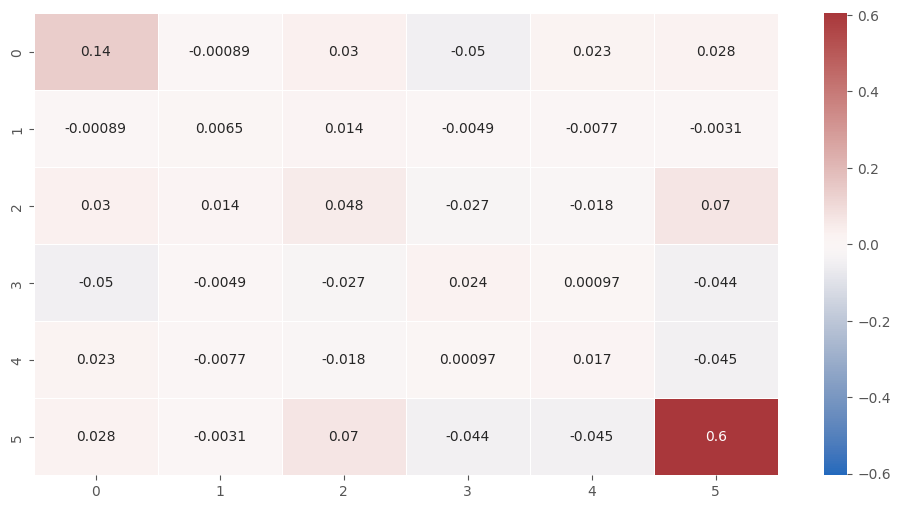

In [110]:
LRBF = LambdaRBF(variance=1.0, randomized=False, d=D)
gpr_lasso_LRBF = GPRLasso(data=(X_train, Y_train),kernel=LRBF,lasso=0.1)
gpflow.utilities.print_summary(gpr_lasso_LRBF, fmt="notebook")
print('--- Initial values ---')
gpr_lasso_LRBF.summary()
gpr_lasso_LRBF.train()
print('--- Optimal values ---')
gpr_lasso_LRBF.summary()
plot_matrix(gpr_lasso_LRBF.kernel.precision())

In [111]:
y_test_pred, _ = gpr_lasso_LRBF.predict_f(X_test)
test_rmse_stan = mean_squared_error(Y_test, y_test_pred, squared=False)
print('Test RMSE (Standardised): %.3f'%(test_rmse_stan))

Test RMSE (Standardised): 0.026


## ARD RBF kernel + GPR (custom)

name,class,transform,prior,trainable,shape,dtype,value
GPRLasso.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPRLasso.kernel.lengthscales,Parameter,Softplus,,True,"(6,)",float64,"[2.44949, 2.44949, 2.44949..."
GPRLasso.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


--- Initial values ---
Kernel variance: 1.0
Lambda diagonal:  [0.13979501 0.00649304 0.04836928 0.02443064 0.01738686 0.60460841]
--- Optimal values ---
Kernel variance: 0.7
Lambda diagonal:  [0.13979501 0.00649304 0.04836928 0.02443064 0.01738686 0.60460841]


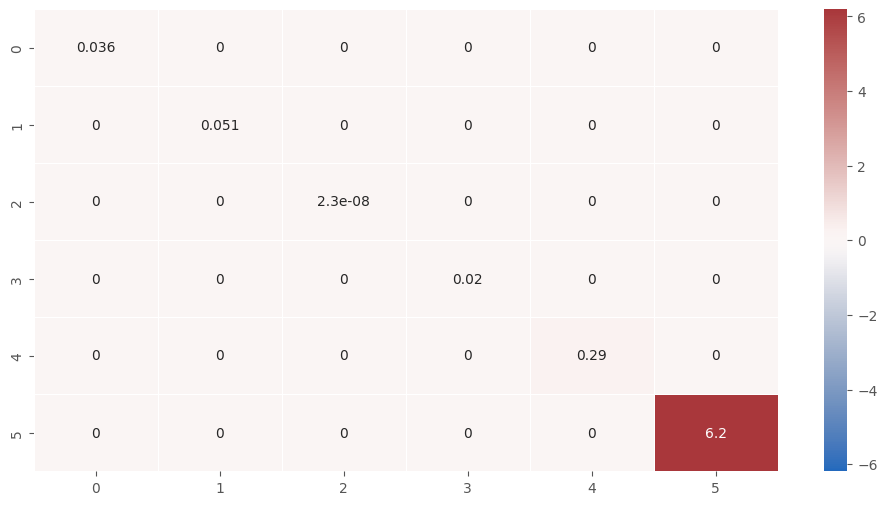

In [112]:
ARD_RBF = ARD_gpflow(variance=1, d=D, randomized=False)
gpr_lasso_RBF = GPRLasso(data=(X_train, Y_train),kernel=ARD_RBF,lasso=0.1)
gpflow.utilities.print_summary(gpr_lasso_RBF, fmt="notebook")
print('--- Initial values ---')
gpr_lasso_RBF.summary()
gpr_lasso_RBF.train()
print('--- Optimal values ---')
gpr_lasso_RBF.summary()
plot_matrix(gpr_lasso_RBF.kernel.precision())

In [97]:
y_test_pred, _ = gpr_lasso_RBF.predict_f(X_test)
test_rmse_stan = mean_squared_error(Y_test, y_test_pred, squared=False)
print('Test RMSE (Standardised): %.3f'%(test_rmse_stan))

Test RMSE (Standardised): 0.039


## ARD RBF kernel + GPR (gpflow)

name,class,transform,prior,trainable,shape,dtype,value
GPR_gpflow.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR_gpflow.kernel.lengthscales,Parameter,Softplus,,True,"(6,)",float64,"[2.44949, 2.44949, 2.44949..."
GPR_gpflow.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


<Parameter: name=softplus, dtype=float64, shape=[6], fn="softplus", numpy=
array([5.23417794e+00, 4.43086052e+00, 4.00634789e+03, 7.11481299e+00,
       1.86828911e+00, 4.01687729e-01])>


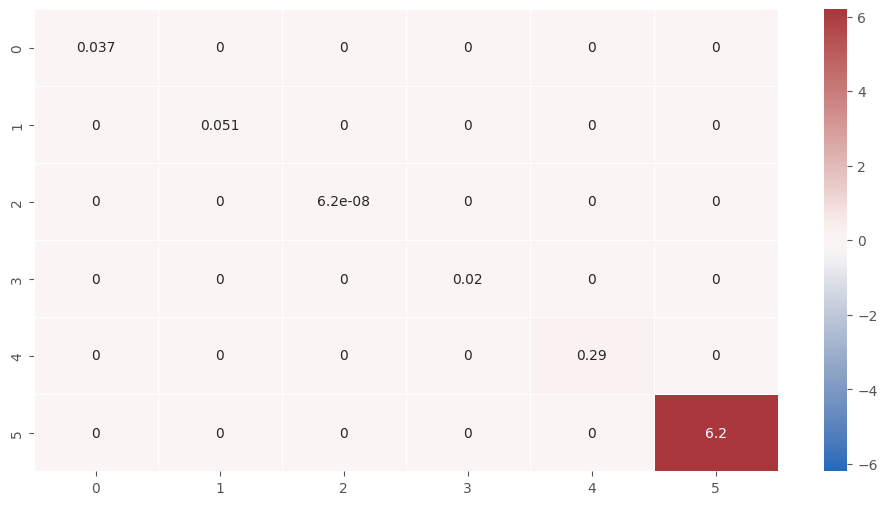

In [109]:
ARD_RBF_gpflow = gpflow.kernels.SquaredExponential(variance=1, lengthscales=(D**0.5)*np.ones(D))
gpr_RBF = GPR_gpflow(data=(X_train, Y_train),kernel=ARD_RBF_gpflow)
gpflow.utilities.print_summary(gpr_RBF, fmt="notebook")
gpr_RBF.train()
plot_matrix(tf.linalg.diag(gpr_RBF.kernel.lengthscales**(-2)))
print(gpr_RBF.kernel.lengthscales)

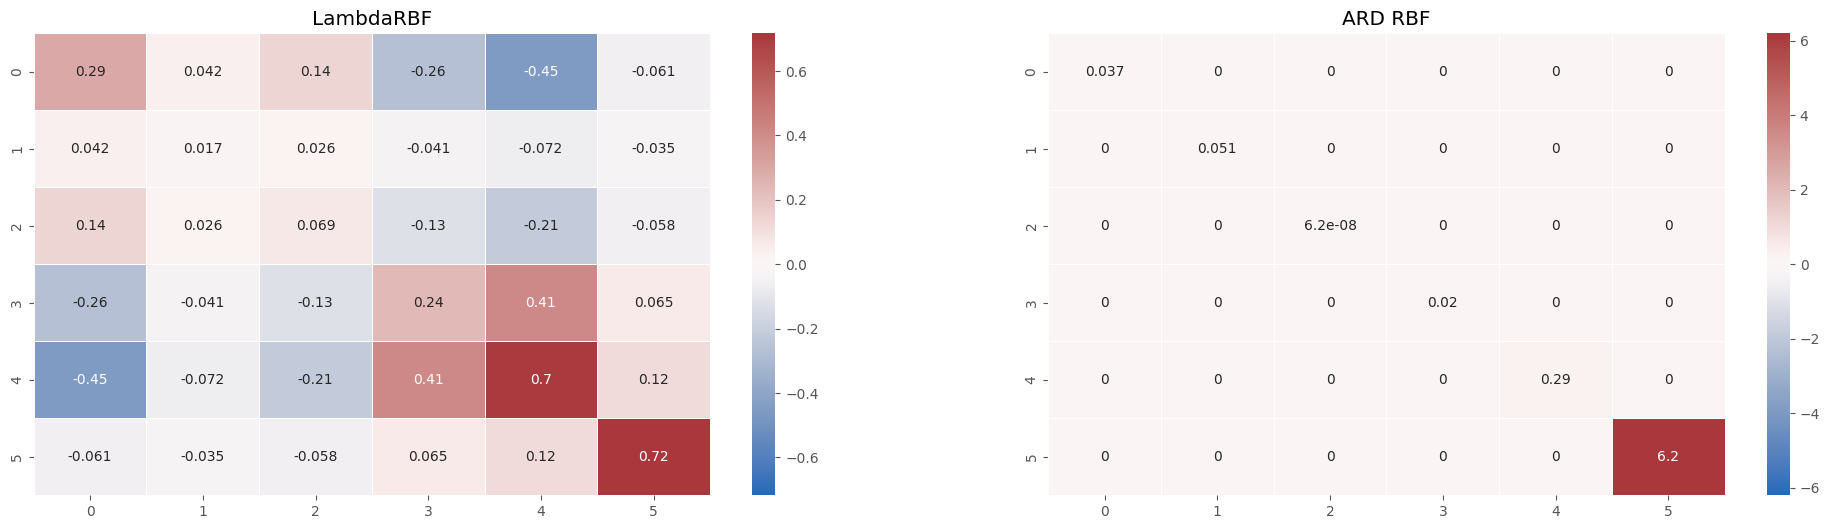

In [108]:
compare_matrix(gpr_lasso_LRBF.kernel.precision(), gpr_lasso_RBF.kernel.precision())

## Introducing a prior on hyperparameters

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.Lambda_L,Parameter,Identity,Normal,True,"(91,)",float64,"[0.27735, 0., 0...."
GPR.kernel.variance,Parameter,Softplus,Normal,True,(),float64,1.0
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


--- Initial values ---
Variance: 1.000
Lambda diagonal:  [0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308
 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308
 0.07692308]
--- Final values ---
Variance: 1.452


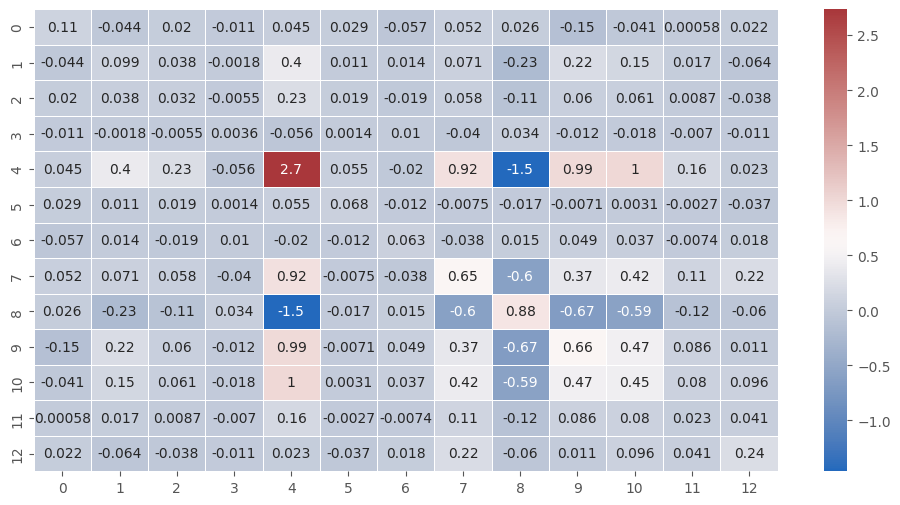

In [15]:
Lambda_L_prior = tfp.distributions.Normal(loc=gpflow.utilities.to_default_float(1.), scale=gpflow.utilities.to_default_float(1.))
variance_prior = tfp.distributions.Normal(loc=gpflow.utilities.to_default_float(0.05), scale=gpflow.utilities.to_default_float(1.))
prior = {'Lambda_L_prior':Lambda_L_prior, 'variance_prior':variance_prior}
model_LRBF = train_GPR_LRBF_model(X_train, Y_train, prior=prior)


In [16]:
train_rmse_stan, test_rmse_stan = measure_rmse(model_LRBF, X_train, Y_train, X_test, Y_test)
print('Train RMSE (Standardised): %.3f'%(train_rmse_stan))
print('Test RMSE (Standardised): %.3f'%(test_rmse_stan))

Train RMSE (Standardised): 0.123
Test RMSE (Standardised): 0.439


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,Normal,True,(),float64,1.0
GPR.kernel.lengthscales,Parameter,Softplus,Normal,True,"(13,)",float64,"[3.60555, 3.60555, 3.60555..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


--- Initial values ---
Variance: 1.000
Lengthscales:  [3.60555128 3.60555128 3.60555128 3.60555128 3.60555128 3.60555128
 3.60555128 3.60555128 3.60555128 3.60555128 3.60555128 3.60555128
 3.60555128]
--- Final values ---
Variance: 0.795
Lengthscales:  [2.61240352 3.59217637 2.66340039 4.14535633 0.85577215 2.46983157
 2.74945467 2.70302672 2.01870868 1.03129203 2.73359412 3.25322002
 1.78116227]


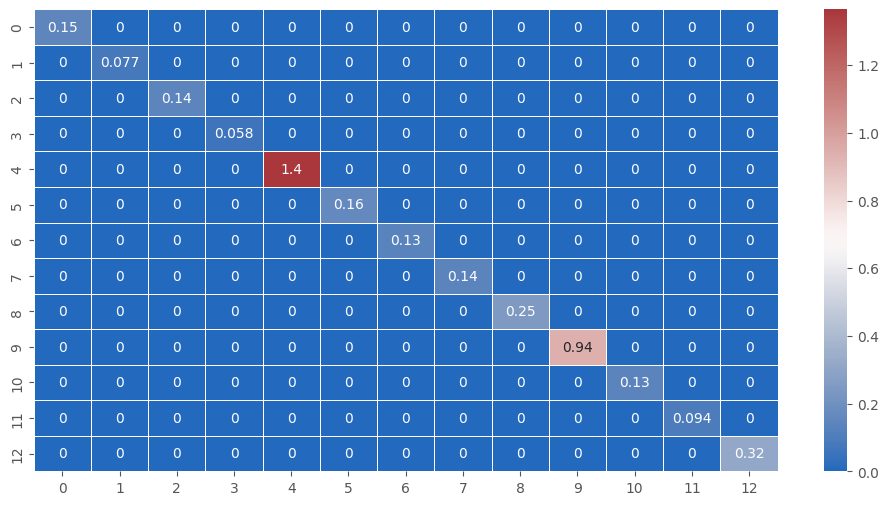

In [17]:
lengthscales_prior = tfp.distributions.Normal(loc=gpflow.utilities.to_default_float(1.), scale=gpflow.utilities.to_default_float(1.))
variance_prior = tfp.distributions.Normal(loc=gpflow.utilities.to_default_float(0.05), scale=gpflow.utilities.to_default_float(1.))
prior = {'lengthscales_prior':lengthscales_prior, 'variance_prior':variance_prior}
model_RBF = train_GPR_RBF_model(X_train, Y_train, prior=prior)


In [18]:
train_rmse_stan, test_rmse_stan = measure_rmse(model_RBF, X_train, Y_train, X_test, Y_test)
print('Train RMSE (Standardised): %.3f'%(train_rmse_stan))
print('Test RMSE (Standardised): %.3f'%(test_rmse_stan))

Train RMSE (Standardised): 0.115
Test RMSE (Standardised): 0.425


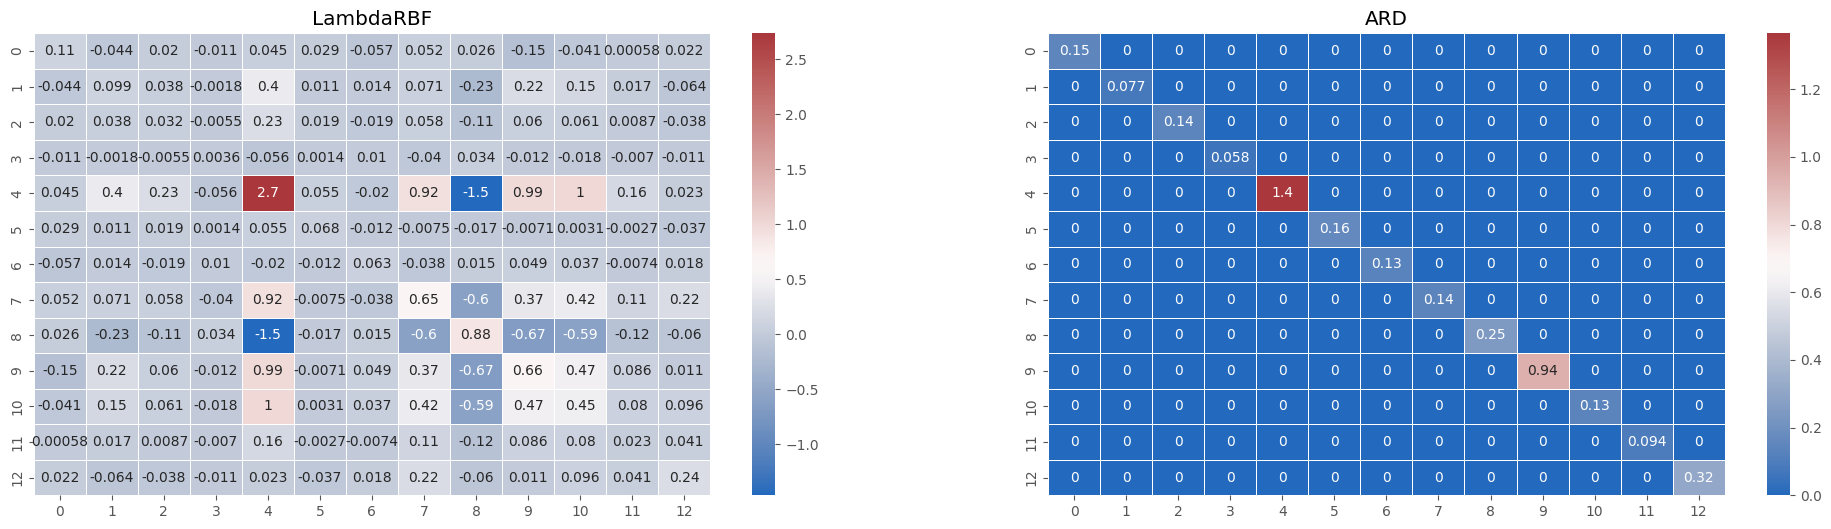

In [19]:
Lambda_LRBF = model_LRBF.kernel.get_Lambda()
Lambda_L_RBF = get_lower_triangular_from_diag(model_RBF.kernel.lengthscales.numpy())
Lambda_RBF = tf.matmul(Lambda_L_RBF, tf.transpose(Lambda_L_RBF))
compare_matrix(Lambda_LRBF, Lambda_RBF)

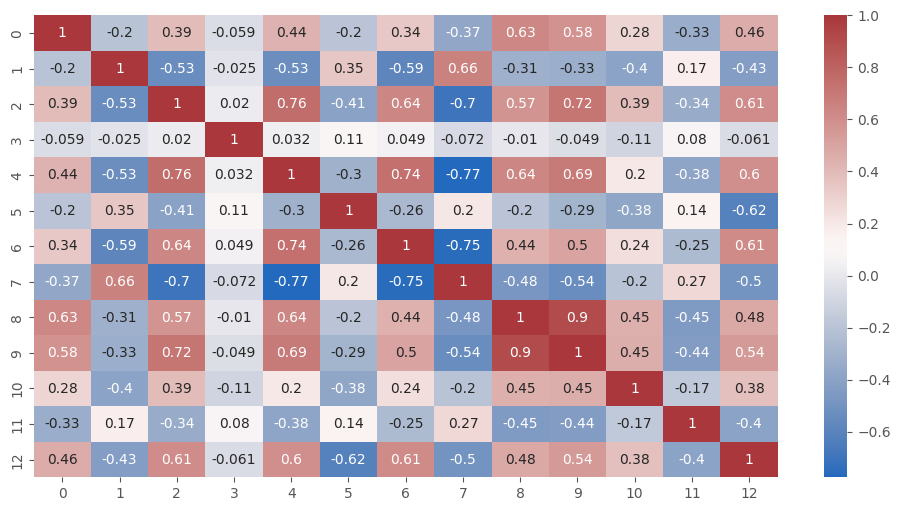

In [20]:
plot_matrix(X_train, correlation=True)